In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def isBetweenUpperAndLowerLimit(value, lower, upper):
    isBetween = value < upper and value > lower
    if isBetween == True:
        return 0
    else:
        return 1
    
# Rule 1: One point is more than 3 standard deviations from the mean (outlier)
def applyRule1(data, mean, sigma):
    upperLimit = mean + 3 * sigma
    lowerLimit = mean - 3 * sigma
    values = [0]*len(data)
    for i in range(len(data)):
        values[i] = isBetweenUpperAndLowerLimit(data.iloc[i]['amount'], lowerLimit, upperLimit)
    data['Rule1'] = values

# Rule 2: Nine (or more) points in a row are on the same side of the mean (shift)
def applyRule2(data, mean):
    values = [0]*len(data)
    upsideOrDownside = 0 # 1 upside, -1 downside
    count = 0
    for i in range(len(data)):
        amount = data.iloc[i]['amount']
        if amount > mean:
            if upsideOrDownside == 1:
                count = count + 1
            else:
                upsideOrDownside = 1
                count = 1
        elif amount < mean: 
            if upsideOrDownside == -1:
                count = count + 1
            else:
                upsideOrDownside = -1
                count = 1
        if count >= 9:
            values[i] = 1
    data['Rule2'] = values
    
# Rule 3: Six (or more) points in a row are continually increasing (or decreasing) (trend)
def applyRule3(data):
    values = [0]*len(data)
    previousAmount = data.iloc[0]['amount']
    increasingOrDecreasing = 0
    count = 0
    for i in range(1, len(data)):
        amount = data.iloc[i]['amount']
        if amount > previousAmount:
            if increasingOrDecreasing == 1:
                count += 1
            else:
                increasingOrDecreasing = 1
                count = 1
        elif amount < previousAmount:   
            if increasingOrDecreasing == -1:
                count += 1
            else:
                increasingOrDecreasing = -1
                count = 1
        if count >= 6:
            values[i] = 1
        previousAmount = amount
     
    data['Rule3'] = values
    
# Rule 4: Fourteen (or more) points in a row alternate in direction, increasing then decreasing (bimodal, 2 or more factors in data set)
def applyRule4(data):
    values = [0]*len(data)
    previousAmount = data.iloc[0]['amount']
    bimodal = 0
    count = 1
    for i in range(1, len(data)):
        amount = data.iloc[i]['amount']
        if amount > previousAmount:
            bimodal = bimodal + 1
            if abs(bimodal) != 1:
                count = 0
                bimodal = 0
            else:
                count = count + 1
        elif amount < previousAmount:
            bimodal = bimodal - 1
            if abs(bimodal) != 1:
                count = 0
                bimodal = 0
            else:
                count = count +1

        previousAmount = amount
        if count >= 14:
            values[i] = 1
    data['Rule4'] = values   
    
# Rule 5: Two (or three) out of three points in a row are more than 2 standard deviations from the mean in the same direction (shift)
def applyRule5(data, mean, sigma):
    if len(data) < 3: return
    values = [0]*len(data)
    upperLimit = mean - 2 * sigma
    lowerLimit = mean + 2 * sigma        

    for i in range(len(data) - 3):
        first = data.iloc[i]['amount']
        second = data.iloc[i+1]['amount']
        third = data.iloc[i+2]['amount']
            
        setValue = False
        validCount = 0
        if first > mean and second > mean and third > mean:
            validCount += 1 if first > lowerLimit else 0
            validCount += 1 if second > lowerLimit else 0
            validCount += 1 if third > lowerLimit else 0
            setValue = validCount >= 2
        elif first < mean and second < mean and third < mean:
            validCount += 1 if first < upperLimit else 0
            validCount += 1 if second < upperLimit else 0
            validCount += 1 if third < upperLimit else 0
            setValue = validCount >= 2

        if setValue:
            values[i+2] = 1

    data['Rule5'] = values

# Rule 6: Four (or five) out of five points in a row are more than 1 standard deviation from the mean in the same direction (shift or trend)
def applyRule6(data, mean, sigma):
    if len(data) < 5: return
    values = [0]*len(data)
    upperLimit = mean - sigma
    lowerLimit = mean + sigma   

    for i in range(len(data) - 5):
        pVals = list(map(lambda x: data.iloc[x]['amount'], range(i, i+5)))

        setValue = False
        if len(list(filter(lambda x: x > mean, pVals))) == 5:
            setValue = len(list(filter(lambda x: x > lowerLimit, pVals))) >= 4
        elif len(list(filter(lambda x: x < mean, pVals))) == 5:
            setValue = len(list(filter(lambda x: x < upperLimit, pVals))) >= 4

        if setValue:
            values[i+4] = 1

    data['Rule6'] = values

# Rule 7: Fifteen points in a row are all within 1 standard deviation of the mean on either side of the mean (reduced variation or measurement issue)
def applyRule7(data, mean, sigma):
    if len(data) < 15: return
    values = [0]*len(data)
    upperLimit = mean + sigma
    lowerLimit = mean - sigma 
        
    for i in range(len(data) - 15):
        setValue = True
        for j in range(15):
            item = data.iloc[i + j]['amount']
            if item >= upperLimit or item <= lowerLimit: 
                setValue = False
                break
            
        if setValue:
            values[i+14] = 1

    data['Rule7'] = values

# Rule 8: Eight points in a row exist with none within 1 standard deviation of the mean and the points are in both directions from the mean (bimodal, 2 or more factors in data set)
def applyRule8(data, mean, sigma):
    if len(data) < 8: return
    values = [0]*len(data)

    for i in range(len(data) - 8):
        setValue = True
        for j in range(8):
            item = data.iloc[i + j]['amount']
            if abs(mean - item) < sigma:
                setValue = False
                break

        if setValue:
            values[i+8] = 1

    data['Rule8'] = values    

## Anomaly Detection Nelson Rules Question 1 Answer:

In [3]:
#Anomaly Detection Nelson Rules for Control Chart
#Question 1 Answer:
data = pd.read_excel("Assignment1_Question1_data.xlsx",name=None)
data = data.drop('day', axis = 1)
trainIndexLimit = 52 * 7 #52 weeks,364 days splitting for training 156-52=104 weeks for testing usage.
trainSet = data[:trainIndexLimit]
testSet = data[trainIndexLimit:]
mean = trainSet['amount'].mean()
standardDeviation = trainSet['amount'].std()
print('Mean of training set: %f' % mean)
print('Standard deviation of training set: %f' % standardDeviation)
weeklyTestData = testSet.groupby('week').mean() #finding weekly testdata mean

applyRule1(weeklyTestData, mean, standardDeviation)
applyRule2(weeklyTestData, mean)
applyRule3(weeklyTestData)
applyRule4(weeklyTestData)
applyRule5(weeklyTestData, mean, standardDeviation)
applyRule6(weeklyTestData, mean, standardDeviation)
applyRule7(weeklyTestData, mean, standardDeviation)
applyRule8(weeklyTestData, mean, standardDeviation)
    
result = weeklyTestData.drop('amount', axis = 1)
pd.set_option('display.max_rows', result.shape[0]+1) # for show all row
print(result)


Mean of training set: 53.639286
Standard deviation of training set: 39.496023
      Rule1  Rule2  Rule3  Rule4  Rule5  Rule6  Rule7  Rule8
week                                                        
53        0      0      0      0      0      0      0      0
54        0      0      0      0      0      0      0      0
55        0      0      0      0      0      0      0      0
56        0      0      0      0      0      0      0      0
57        0      0      0      0      0      0      0      0
58        0      0      0      0      0      0      0      0
59        0      0      1      0      0      0      0      0
60        0      0      1      0      0      0      0      0
61        0      0      1      0      0      0      0      0
62        0      0      0      0      0      0      0      0
63        0      0      0      0      0      0      0      0
64        0      0      0      0      0      0      0      0
65        0      0      0      0      0      0      0      0
66     

In [4]:
def plot_rules(data):
        columns = data.columns[1:]
        fig, axs = plt.subplots(len(columns), 1, figsize=(20, 20))
        fig.subplots_adjust(hspace=1, wspace=.5)

        axs = axs.ravel()

        for i in range(len(columns)):
            axs[i].plot(data.ix[:, 0])
            axs[i].plot(data.ix[:, 0][(data.ix[:, i+1] == True)], 'ro')
            axs[i].set_title(columns[i])
        return fig

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


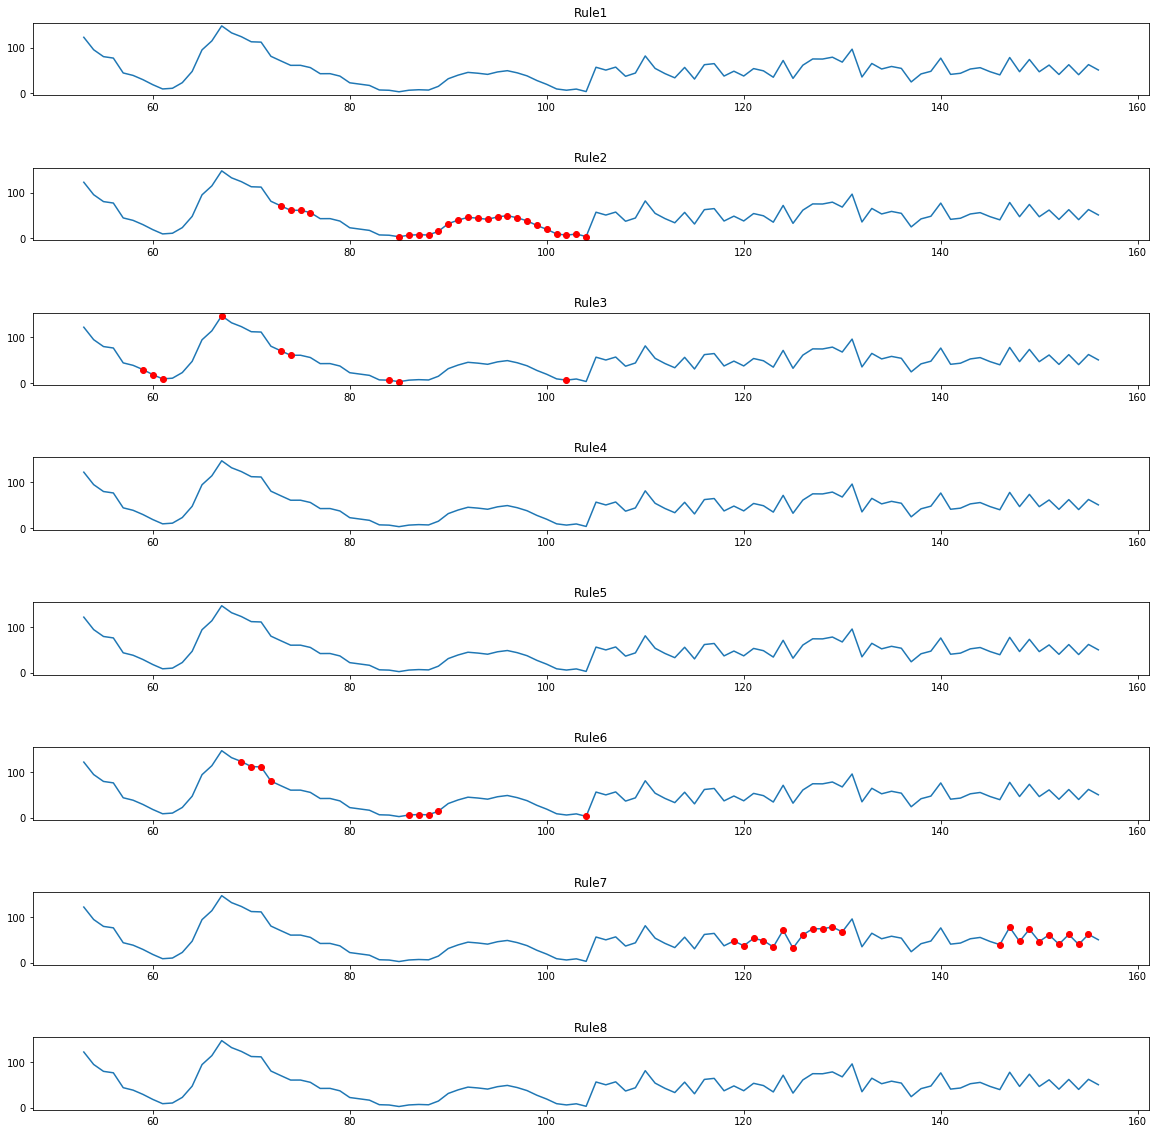

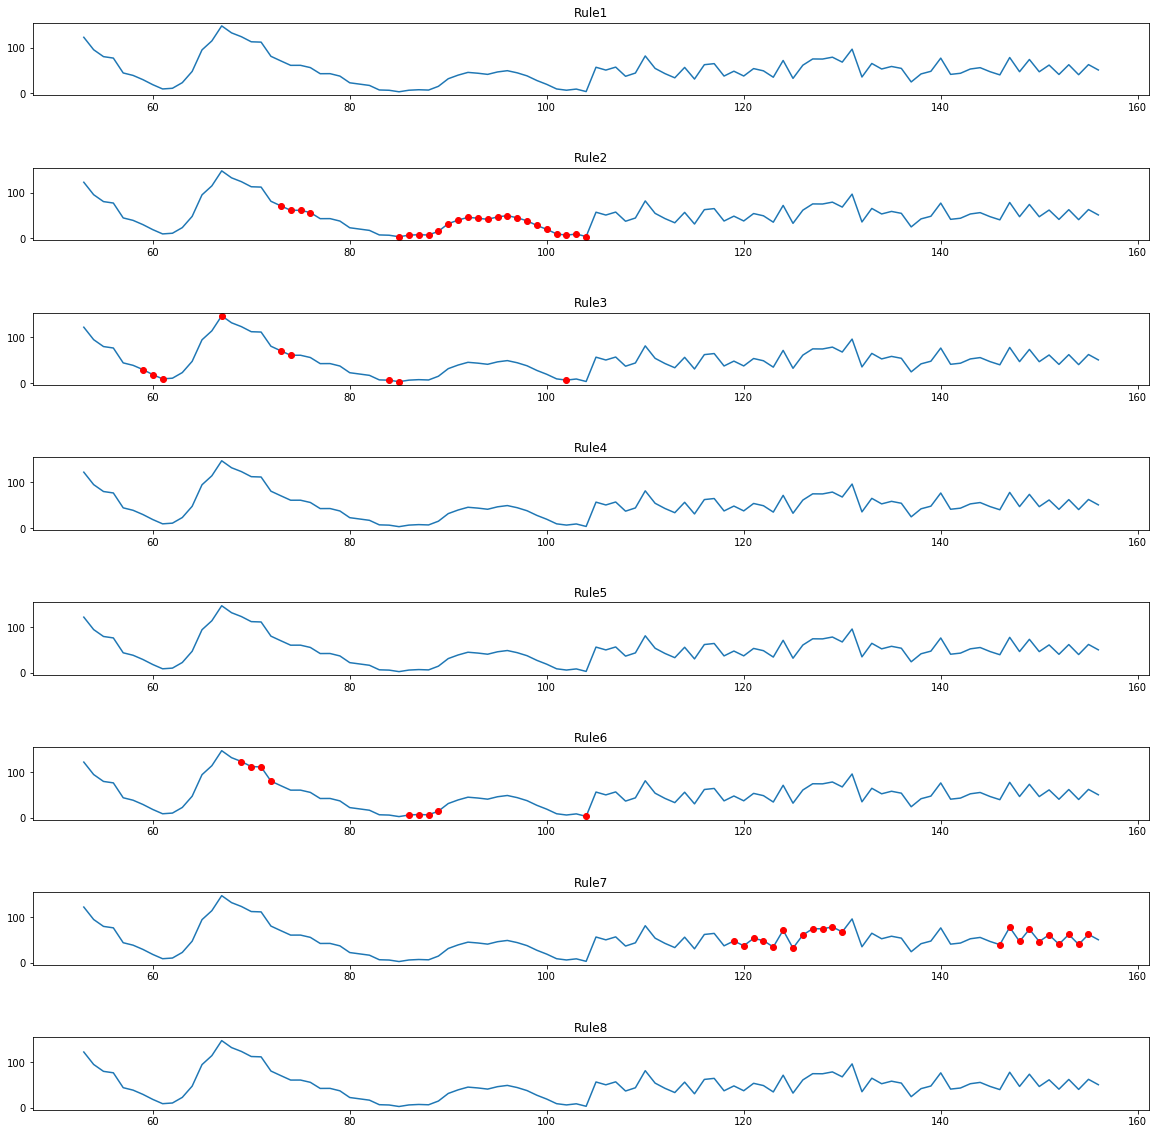

In [5]:
plot_rules(weeklyTestData) #for showing the outlier value plotting

## Question 2- Naive Bayes Learning Option 2:

In [6]:
class Weather():
        def __init__(self, Outlook, Temp,Humidity,Windy,Play):
            self.Outlook = Outlook
            self.Temp = Temp
            self.Humidity = Humidity
            self.Windy = Windy
            self.Play = Play
            

In [7]:
def WeatherList():
    #degerler slaytdan alınmıştır
    weatherList = []
    weatherList.append(Weather("Sunny","Hot","High","F","No"))
    weatherList.append(Weather("Sunny","Hot","High","T","No"))
    weatherList.append(Weather("Overcast","Hot","High","F","Yes"))
    weatherList.append(Weather("Rainy","Mild","High","F","Yes"))
    weatherList.append(Weather("Rainy","Cool","Normal","F","Yes"))
    weatherList.append(Weather("Rainy","Cool","Normal","T","No"))
    weatherList.append(Weather("Overcast","Cool","Normal","T","Yes"))
    weatherList.append(Weather("Sunny","Mild","High","F","No"))
    weatherList.append(Weather("Sunny","Cool","Normal","F","Yes"))
    weatherList.append(Weather("Rainy","Mild","Normal","F","Yes"))
    weatherList.append(Weather("Sunny","Mild","Normal","T","Yes"))
    weatherList.append(Weather("Overcast","Mild","High","T","Yes"))
    weatherList.append(Weather("Overcast","Hot","Normal","F","Yes"))
    weatherList.append(Weather("Rainy","Mild","High","T","No"))
    return weatherList

In [8]:
def mappingForOutlook(value):
    if(value == "Sunny"):
        return 0
    elif(value == "Overcast"):
        return 1
    else:
        return 2

In [9]:
def mappingForTemp(value):
    if(value == "Hot"):
        return 0
    elif(value == "Mild"):
        return 1
    else:
        return 2

In [10]:
def mappingForHumidity(value):
    if(value == "High"):
        return 0
    else:
        return 1

In [11]:
def mappingForWindy(value):
    if(value == "T"):
        return 1
    else:
        return 0

In [12]:
def mappingForLabel(value):
    if(value == "Yes"):
        return 1
    else:
        return 0

In [13]:
def changeData():
    weatherList=WeatherList();
    data = []
    outcome = []
    for i in range(len(weatherList)):
        data.append([mappingForOutlook(weatherList[i].Outlook),
                     mappingForTemp(weatherList[i].Temp),
                     mappingForHumidity(weatherList[i].Humidity),
                     mappingForWindy(weatherList[i].Windy)])
        outcome.append(mappingForLabel(weatherList[i].Play))

    data = np.asarray(data)     
    outcome = np.asarray(outcome)
    return data,outcome

In [14]:

#Function for calculating the prior probabilities
def occurrences(outcome):
    no_of_examples = len(outcome)
    prob = dict(Counter(outcome))
    for key in prob.keys():
        if(prob[key]):
            prob[key] = prob[key] / float(no_of_examples)
        else:
            prob[key] = (prob[key]+1) / float(no_of_examples+1) 
    return prob



def naive_bayes(training, outcome, new_sample):
    classes     = np.unique(outcome)
    rows, cols  = np.shape(training)
    likelihoods = {}
    likelihoods_prob = {}
    for cls in classes:
        likelihoods[cls] = defaultdict(list)
        likelihoods_prob[cls] = defaultdict(list)
    class_probabilities = occurrences(outcome)
 
    for cls in classes:
        row_indices = np.where(outcome == cls)[0]
        subset      = training[row_indices, :]
        r, c        = np.shape(subset)
        for j in range(0,c):
            likelihoods[cls][j] += list(subset[:,j])
            #the occurrences for each feature is saved in likelihoods
 
    for cls in classes:
        for j in range(0,cols):
             likelihoods_prob[cls][j] = occurrences(likelihoods[cls][j])
             #likelihoods_prob contain the probabilities per feature per class.
 
    results = {}
    for cls in classes:
         class_probability = class_probabilities[cls]
         for i in range(0,len(new_sample)):
             relative_values = likelihoods_prob[cls][i]
             if new_sample[i] in relative_values.keys():
                 class_probability *= relative_values[new_sample[i]]
             #else:
               #  class_probability *= 0
             results[cls] = class_probability
    #print (results)
    return results

In [15]:
import csv
import random
import math
import numpy as np
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
random.seed() 
data,outcome = changeData()
X_train, X_test, y_train, y_test = train_test_split(data, outcome, test_size=0.30, random_state=42)
y_pred = []


for i in range(len(X_test)):
    result=naive_bayes(X_train, y_train, X_test[i])
    if(result[0]>result[1]):
        y_predic=0
    else:
        y_predic=1
    y_pred.append(y_predic)
y_pred = np.asarray(y_pred)  
confusionMatrix = confusion_matrix(y_test, y_pred)

TrueNegative=confusionMatrix[0,0]
TruePositive=confusionMatrix[1,1]
FalsePositive=confusionMatrix[0,1]
FalseNegative=confusionMatrix[1,0]

accuracy=(TruePositive+TrueNegative)/(TrueNegative+TruePositive+FalsePositive+FalseNegative)
precision=(TruePositive)/(TruePositive+FalsePositive)
specificty=(TrueNegative)/(TrueNegative+FalsePositive)
sensitivity=(TruePositive)/( TruePositive+FalseNegative)
print('Accuracy: %f' % accuracy)
print('Precision: %f' % precision)
print('Specificty: %f' % specificty)
print('Sensitivity: %f' % sensitivity)

Accuracy: 0.600000
Precision: 1.000000
Specificty: 1.000000
Sensitivity: 0.333333
